# Math 124 - Programming for Mathematical Applications
UC Berkeley, Spring 2024

## Project 3 - Triangular mesh generator

Due Friday, March 22

First we include some libraries and define utility functions from the lecture notes:

In [1]:
using PyPlot, LinearAlgebra, Delaunator

function tplot(p, t)
    # Plot triangular mesh with nodes `p` and triangles `t`
    tris = convert(Array{Int64}, hcat(t...)')
    tripcolor(first.(p), last.(p), tris .- 1, 0*tris[:,1],
              cmap="Set3", edgecolors="k", linewidth=1)
    axis("equal")
    return
end

# Delaunay triangulation `t` of array of nodes `p`
delaunay(p) = collect.(triangulate(p).triangles)

[ Info: Precompiling PyPlot [d330b81b-6aea-500a-939a-2ce795aea3ee]
[ Info: Precompiling Delaunator [466f8f70-d5e3-4806-ac0b-a54b75a91218]


delaunay (generic function with 1 method)

### Description

In this project you will write an unstructured triangular mesh generator based on the Delaunay refinement algorithm. The steps will be described in detail, and for testing we will use the following simple polygon:

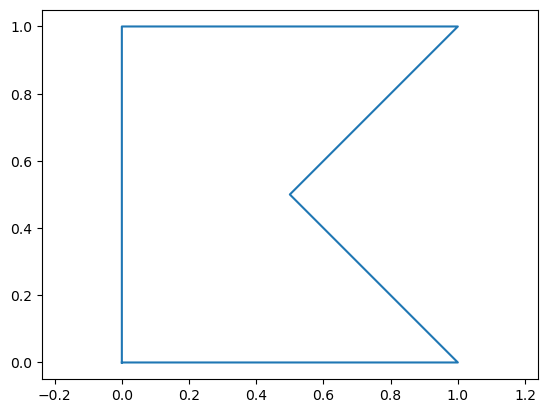

In [2]:
pv = [[0,0], [1,0], [0.5,.5], [1,1], [0,1], [0,0]]
plot(first.(pv), last.(pv))
axis("equal");

### Problem 1 - Point in polygon

Write a function `inpolygon(p, pv)` which determines if a point `p` is inside the closed polygon `pv`. For example, in the test polygon above, the point $(0.6,0.3)$ is inside but $(0.8,0.3)$ is outside. For the algorithm, use the "Crossing number method" as described here: <https://observablehq.com/@tmcw/understanding-point-in-polygon>.

In [3]:
function inpolygon(p,pv)
    n = length(pv)
    x,y = p

    inside = false
    for i in 1:n
        j = i % n + 1
        if ((pv[i][2] > y) != (pv[j][2] > y)) && (x < (pv[j][1] - pv[i][1]) * (y - pv[i][2]) / (pv[j][2] - pv[i][2]) + pv[i][1])
            inside = !inside
        end
    end
    return inside
end

#testing
pv = [[0,0], [1,0], [0.5,.5], [1,1], [0,1], [0,0]]
p = [0.6, 0.3]
inpolygon(p, pv)

true

### Problem 2 - Triangle properties

Next we need functions for computing some basic quantities from triangles. Here, a triangle `tri` is represented as an array of 3 points, e.g.

In [45]:
tri = [[1,0.5], [2,1], [0,3]]

3-element Vector{Vector{Float64}}:
 [1.0, 0.5]
 [2.0, 1.0]
 [0.0, 3.0]

### Problem 2(a) - Triangle area

Write a function `tri_area(tri)` which returns the area of `tri`.

In [5]:
function tri_area(tri)
    x1, y1 = tri[1]
    x2, y2 = tri[2]
    x3, y3 = tri[3]
    
    area = 0.5 * abs(x1 * (y2 - y3) + x2 * (y3 - y1) + x3 * (y1 - y2))
    
    return area
end

tri_area(tri)

1.5

### Problem 2(b) - Triangle centroid

Write a function `tri_centroid(tri)` which returns the centroid of `tri` (<https://en.wikipedia.org/wiki/Centroid#Of_a_triangle>).

In [59]:
function tri_centroid(tri)
    x1,y1 = tri[1]
    x2,y2 = tri[2]
    x3,y3 = tri[3]

    centroid = ((x1 + x2 + x3) / 3, (y1 + y2 + y3) / 3)
    return centroid
end

tri_centroid (generic function with 1 method)

### Problem 2(c) - Triangle circumcenter

Write a function `tri_circumcenter(tri)` which returns the circumcenter of `tri` (<https://en.wikipedia.org/wiki/Circumcircle#Cartesian_coordinates_2>).

In [8]:
function tri_circumcenter(tri)
    x1,y1 = tri[1]
    x2,y2 = tri[2]
    x3,y3 = tri[3]
    
    a = x2 - x1
    b = y2 - y1
    c = x3 - x1
    d = y3 - y1
    
    e = a * (x1 + x2) + b * (y1 + y2)
    f = c * (x1 + x3) + d * (y1 + y3)
    
    denom = 2 * (a * d - b * c)
    
    xc = (d * e - b * f) / denom
    yc = (a * f - c * e) / denom
    
    return (xc, yc)
end

tri_circumcenter (generic function with 1 method)

### Problem 3 - Mesh generator

Write a function with the syntax `p,t = pmesh(pv, hmax)` which generates a mesh `p,t` of the polygon `pv`, with triangle side lengths approximately `hmax`. Follow the algorithm as described below.

(a) The input `pv` is an array of points which defines the polygon. Note that the last point is equal to the first (a closed polygon).

(b) First, create node points `p` along each polygon segment, separated by a distance approximately equal to `hmax`. Make sure not to duplicate any nodes.

(c) Triangulate the domain using the `delaunay` function.

(d) Remove the triangles outside the polygon, by computing all the triangle centroids (using `tri_centroid`) and determining if they are inside (using `inpolygon`).

(e) Find the triangle with largest area $A$ (using `tri_area`). If $A>h_\mathrm{max}^2/2$, add the circumcenter of the triangle to the list of node points `p`.

(f) Repeat steps (c)-(d), that is, re-triangulate and remove outside triangles.

(g) Repeat steps (e)-(f) until no triangle area $A>h_\mathrm{max}^2/2$.

![mesh_generator.png](https://github.com/popersson/math124files/raw/main/projects/mesh_generator.png)

In [116]:
function pmesh(pv, hmax)
    # (b)
    n = length(pv) - 1
    p = []
    for i in 1:n
        seg = norm(pv[i % n + 1] - pv[i])
        num_points =  ceil(seg/hmax)
        δ = (pv[i + 1] - pv[i]) / num_points
        for j in 0:num_points
            new = pv[i] + j * δ
            if !in(new, p)
                push!(p, new)
            end
        end
    end

    # (c)
    t = delaunay(p)
    function triangle_vertices(pv, t, triangle_index) # helper function that takes the triangles from t and returns their coordinates
        triangle_vertex_indices = t[triangle_index]
        return [pv[index] for index in triangle_vertex_indices]
    end
    
    while true # (g) while loop will repeat steps (e)-(f)
        inpoly = []
        #(d)
        for tri_index in 1:length(t)
            vertices = triangle_vertices(p, t, tri_index)
            centroid = tri_centroid(vertices)
            if inpolygon(centroid, pv)
                push!(inpoly, t[tri_index])
            end
        end
        t = inpoly
        
        # (e)
        areas = [tri_area(triangle_vertices(p,t,idx)) for idx in 1:length(t)]
        max_area = maximum(areas)
        max_area_index = argmax(areas)
        if max_area > hmax^2 / 2
            circumcenter = tri_circumcenter(triangle_vertices(p,t,max_area_index))
            push!(p, circumcenter)
            t = delaunay(p)
        else
            break
        end
    end
    return p, t
end

pmesh (generic function with 1 method)

### Test cases

Run the cases below to test your mesh generator.

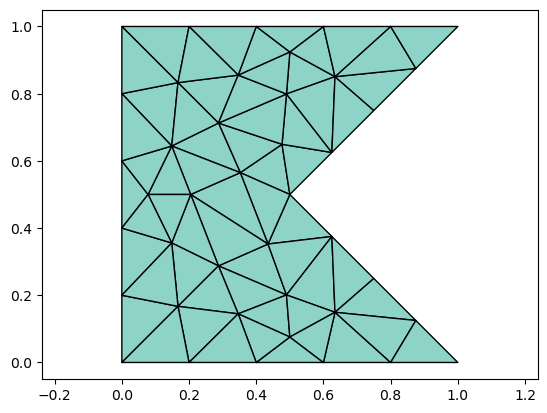

In [117]:
# The polygon in the examples
pv = [[0,0], [1,0], [0.5,.5], [1,1], [0,1], [0,0]]
p,t = pmesh(pv, 0.2)
tplot(p,t)

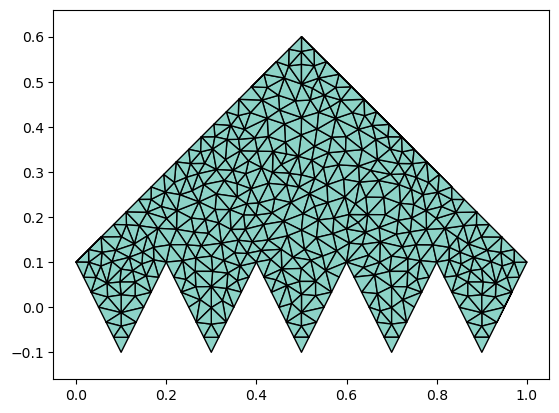

In [118]:
# A more complex shape
pv = [[i/10,0.1*(-1)^i] for i = 0:10]
append!(pv, [[.5,.6], [0,.1]])
p,t = pmesh(pv, 0.04)
tplot(p,t)